In [1]:
knitr::opts_chunk$set(echo = TRUE)

rm(list = ls())

# Chargement des librairies
library("tidyverse")
library("text")
library("kableExtra")
library("e1071")
library("tm")
library("wordcloud")
library("caret")
library("text")
library("tidytext")
library("spacyr")

data <- read.csv("Emotion_classify_Data.csv", stringsAsFactors = FALSE)
head(data, 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is text (version 1.0).
Text is new and still rapidly improving.
               
Newer versions may have improved functions and updated defaults to reflect current understandings of the state-of-the-art.
               Please send us feedback based on your experience.

Please note that defaults has changed in the textEmbed-functions since last version; see help(textEmbed) or www.r-text.org for more details.


Attaching package: 'kableExtra'


The following object is m

,Comment,Emotion
,<chr>,<chr>
1,i seriously hate one subject to death but now i feel reluctant to drop it,fear
2,im so full of life i feel appalled,anger
3,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it,fear
4,ive been really angry with r and i feel like an idiot for trusting him in the first place,joy
5,i feel suspicious if there is no one outside like the rapture has happened or something,fear
6,i feel jealous becasue i wanted that kind of love the true connection between two souls and i wanted that,anger
7,when a friend of mine keeps telling me morbid things that happened to his dog,anger
8,i finally fell asleep feeling angry useless and still full of anxiety,anger
9,i feel a bit annoyed and antsy in a good way,anger


In [2]:
#spacy_install()
spacy_initialize(model = "en_core_web_sm")

successfully initialized (spaCy Version: 3.7.2, language model: en_core_web_sm)



In [3]:
stopWords2 <- c(stopwords("english"), 'feel', 'feeling', 'really', 'time', 'im', 'know', 'make', 'little')

# Fonction de prétraitement avec lemmatisation
preprocess <- function(text) {
  # Création d'un corpus
  corpus <- VCorpus(VectorSource(text))  
  # Nettoyage des données
  corpus <- tm_map(corpus, content_transformer(tolower))
  corpus <- tm_map(corpus, removePunctuation)
  corpus <- tm_map(corpus, removeNumbers)
  corpus <- tm_map(corpus, removeWords, stopWords2)

  # Lemmatisation avec spacyr
  lemmatized_text <- sapply(corpus, function(x) {
    parsed <- spacy_parse(as.character(x), lemma = TRUE)
    paste(parsed$lemma, collapse = " ")
  })

  return(lemmatized_text)
}

# Appliquer la fonction de prétraitement
data$preprocessed_comment <- sapply(data$Comment, preprocess)


In [4]:
data$Emotion_num <- match(data$Emotion, c('joy', 'fear', 'anger')) - 1
head(data, 5)

,Comment,Emotion,preprocessed_comment,Emotion_num
,<chr>,<chr>,<chr>,<dbl>
1,i seriously hate one subject to death but now i feel reluctant to drop it,fear,seriously hate one subject death now reluctant drop,1
2,im so full of life i feel appalled,anger,full life appal,2
3,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it,fear,sit write start dig feeling think afraid accept possibility might,1
4,ive been really angry with r and i feel like an idiot for trusting him in the first place,joy,I ve angry r like idiot trust first place,0
5,i feel suspicious if there is no one outside like the rapture has happened or something,fear,suspicious one outside like rapture happen something,1


<<TermDocumentMatrix (terms: 6, documents: 5937)>>
Non-/sparse entries: 646/34976
Sparsity           : 98%
Maximal term length: 9
Weighting          : term frequency (tf)

like  not just  get  can want 
1007  593  531  500  490  348

,term,freq
,<chr>,<dbl>
like,like,1007
not,not,593
just,just,531
get,get,500
can,can,490
want,want,348


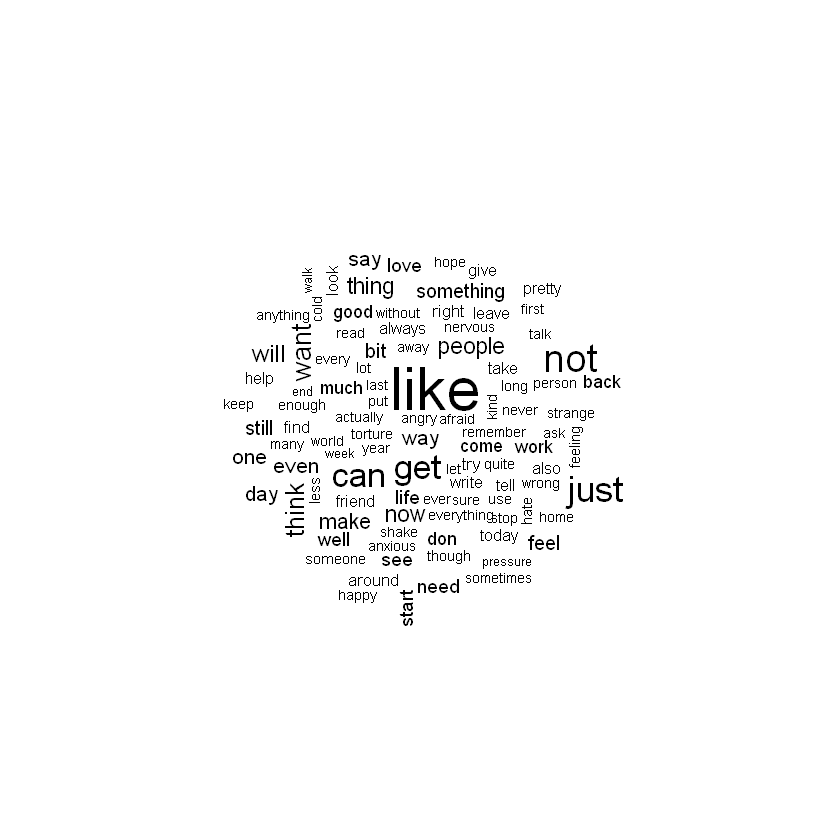

In [14]:
text <- data$preprocessed_comment
# Création d'un corpus à partir de vos données prétraitées
corpus <- Corpus(VectorSource(text))

# Création d'une matrice de termes-document
dtm <- TermDocumentMatrix(corpus)

# Calcul des fréquences de termes
term_frequencies <- sort(rowSums(as.matrix(dtm)), decreasing = TRUE)

# Création d'un data frame avec les termes et leurs fréquences
term_freq_df <- data.frame(term = names(term_frequencies), freq = term_frequencies)



# Création du nuage de mots avec les mots et leurs fréquences
wordcloud(words = term_freq_df$term, freq = term_freq_df$freq, scale=c(3,0.5), max.words=100)

[1] "Nuage de mots pour l'émotion: fear"
[1] "Nuage de mots pour l'émotion: anger"


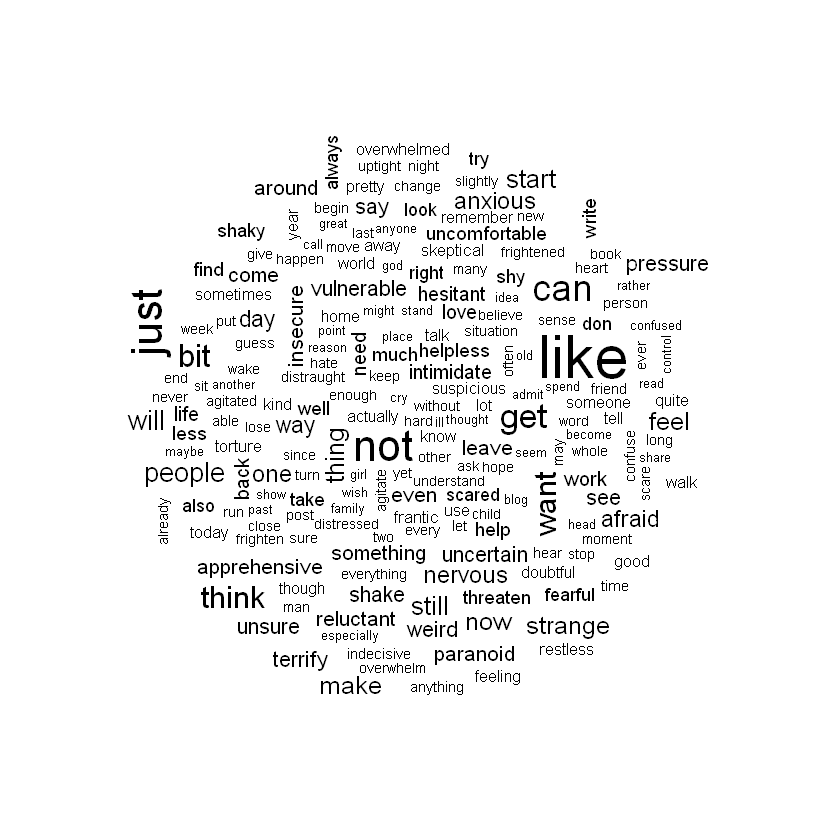

[1] "Nuage de mots pour l'émotion: joy"


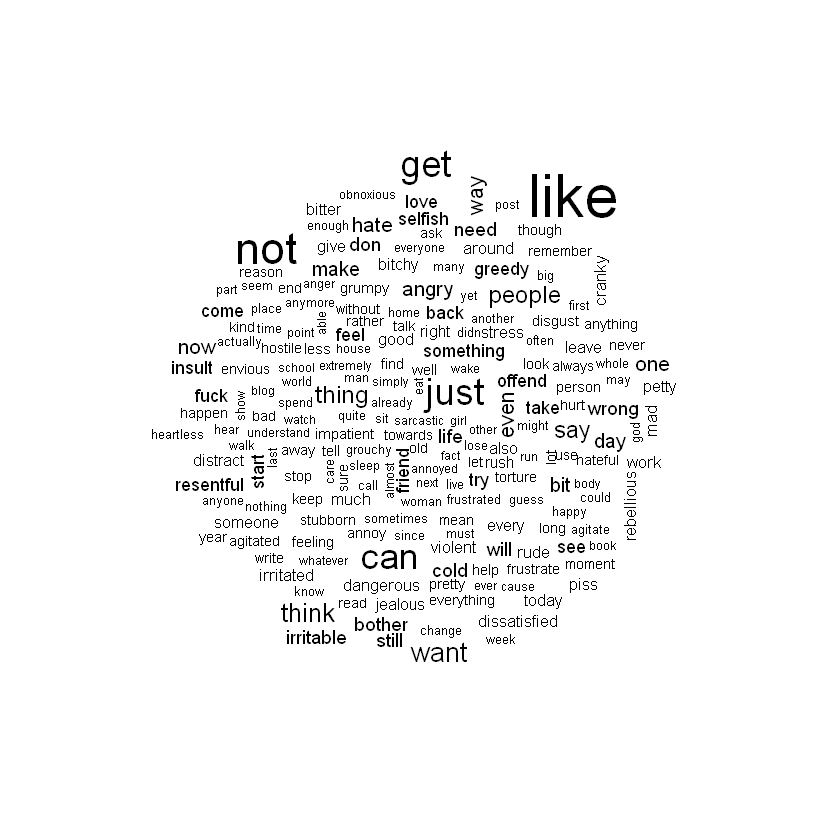

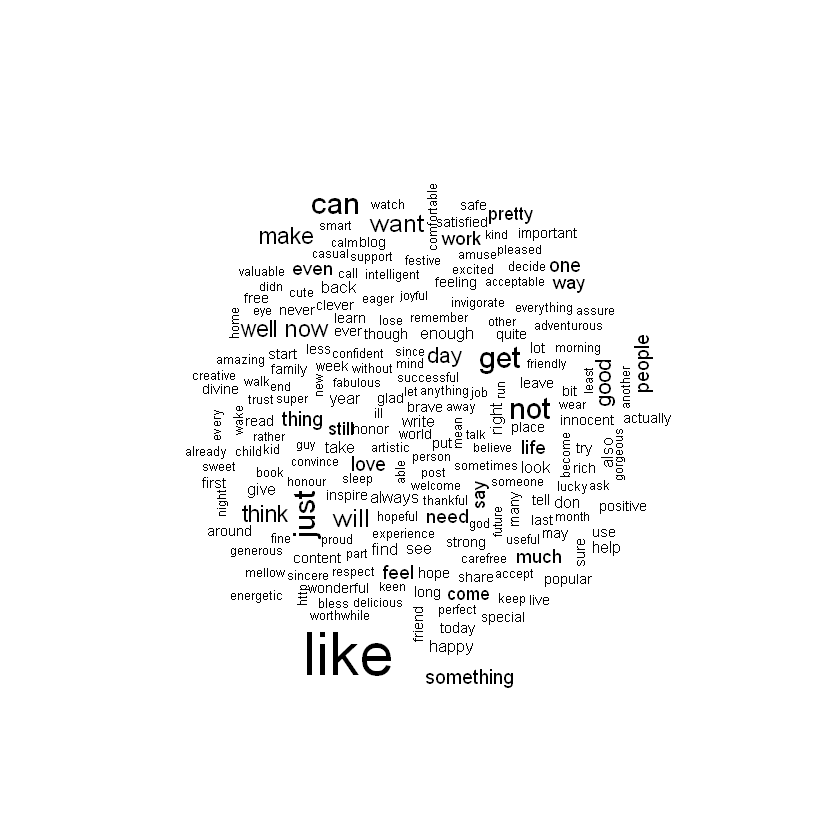

In [16]:
# Liste des émotions à traiter
emotions <- unique(data$Emotion)

# Boucle pour créer un nuage de mots pour chaque émotion
for (emotion in emotions) {
  # Création d'un sous-ensemble pour l'émotion spécifique
  data_subset <- data[data$Emotion == emotion, ]
  
  # Création d'un corpus à partir des données prétraitées
  corpus <- Corpus(VectorSource(data_subset$preprocessed_comment))
  
  # Création d'une matrice de termes-document
  dtm <- TermDocumentMatrix(corpus)
  
  # Calcul des fréquences de termes
  term_frequencies <- rowSums(as.matrix(dtm))
  
  # Création d'un data frame avec les termes et leurs fréquences
  term_freq_df <- data.frame(term = names(term_frequencies), freq = term_frequencies)
  
  # Tri des termes par fréquence décroissante
  term_freq_df <- term_freq_df[order(-term_freq_df$freq), ]
  
  # Création du nuage de mots pour l'émotion spécifique
  print(paste("Nuage de mots pour l'émotion:", emotion))
  wordcloud(words = term_freq_df$term, freq = term_freq_df$freq, scale=c(3,0.5), max.words=200)
}


In [5]:
library("caret")

# Assurez-vous que df est votre dataframe et qu'il contient les colonnes 'preprocessed_comment' et 'Emotion_num'

# Création d'un index pour le partitionnement stratifié
set.seed(42)
trainIndex <- createDataPartition(data$Emotion_num, p = 0.8, list = FALSE, times = 1)

# Séparation des données en ensembles d'entraînement et de test
X_train <- data$preprocessed_comment[trainIndex]
y_train <- data$Emotion_num[trainIndex]
X_test <- data$preprocessed_comment[-trainIndex]
y_test <- data$Emotion_num[-trainIndex]

In [6]:
library(text2vec)

# Assurez-vous que X_train et X_test sont disponibles et contiennent les données textuelles

# Création d'un itérateur sur les documents
it_train <- itoken(X_train, progressbar = FALSE)
it_test <- itoken(X_test, progressbar = FALSE)

# Création du vocabulaire et du vectoriseur
vocab <- create_vocabulary(it_train)
vectorizer <- vocab_vectorizer(vocab)

# Transformation des données d'entraînement et de test en utilisant TF-IDF
tfidf_transformer <- TfIdf$new()
dtm_train <- create_dtm(it_train, vectorizer) %>%
  tfidf_transformer$fit_transform()
dtm_test <- create_dtm(it_test, vectorizer) %>%
  tfidf_transformer$transform()

# Affichage des 20 premiers termes du vocabulaire
print(head(vocab$term, 20))



 [1] "aac"         "ab"          "abandonment" "abbigail"    "abdomen"    
 [6] "abelard"     "abnormally"  "abound"      "abroad"      "abruptly"   
[11] "absence"     "absolute"    "absolutly"   "absorb"      "abstract"   
[16] "absurdity"   "abuse"       "abyss"       "academia"    "accelerate" 


In [8]:
# Assumons que dtm_train est votre Document-Term Matrix et y_train est votre vecteur de réponse
library("naivebayes")

# Entraînement du modèle Naive Bayes
NB_model <- multinomial_naive_bayes(as.matrix(dtm_train), as.factor(y_train), laplace = 1)
summary(NB_model)
# NB_model est maintenant le modèle entraîné


In [19]:
# Classification
predictions <- predict(NB_model, newdata = as.matrix(dtm_test), type = "class")
# Conversion des prédictions et des valeurs réelles en facteurs avec les mêmes niveaux
levels <- sort(unique(c(y_train, y_test))) # Fusion et tri des niveaux uniques dans les données d'entraînement et de test
predictions_factor <- factor(predictions, levels = levels)
y_test_factor <- factor(y_test, levels = levels)

# Calcul de la matrice de confusion
conf_matrix <- confusionMatrix(predictions_factor, y_test_factor)

# Affichage de la matrice de confusion
print(conf_matrix)

In [17]:

# Fonction pour tester le modèle avec un paramètre donné
test_model <- function(laplace) {
  model <- multinomial_naive_bayes(as.matrix(dtm_train), as.factor(y_train), laplace = laplace)
  predictions <- predict(model, as.matrix(dtm_test))
  confusionMatrix <- table(Predicted = factor(predictions, levels = levels), Actual = factor(y_test, levels = levels))
  accuracy <- sum(diag(confusionMatrix)) / sum(confusionMatrix)
  return(accuracy)
}

# Gamme de valeurs pour le paramètre 'laplace'
laplace_values <- seq(0, 1, by = 0.1)

# Recherche en grille
results <- sapply(laplace_values, test_model)

# Trouver la meilleure valeur
best_laplace <- laplace_values[which.max(results)]
best_accuracy <- max(results)

print(paste("Meilleur Laplace:", best_laplace))
print(paste("Meilleure Exactitude:", best_accuracy))


Warning message:
"multinomial_naive_bayes(): there are 9118 empty cells leading to zero estimates. Consider Laplace smoothing."


[1] "Meilleur Laplace: 1"
[1] "Meilleure Exactitude: NaN"
